In [67]:
# Core imports
import requests
import os
from dotenv import load_dotenv
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Visualization imports
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
from collections import Counter

# Configure matplotlib
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

# Load API key
load_dotenv()
finnhub_key = os.getenv("FINNHUB_API_KEY")
if not finnhub_key:
    raise ValueError("⚠️ Please add your FINNHUB_API_KEY to .env file")

print("✅ All libraries loaded and API key ready")

✅All libraries loaded and API key ready


In [68]:
# Function to clean headlines
def clean_text(text):
    if not text:
        return ""
    text = text.strip()
    text = re.sub(r"[^\w\s.,?!]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text

# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

# Function to classify sentiment
def get_sentiment_vader(text):
    scores = analyzer.polarity_scores(text)
    compound = scores['compound']
    if compound >= 0.05:
        return "Bullish"
    elif compound <= -0.05:
        return "Bearish"
    else:
        return "Neutral"

In [69]:
def extract_keywords(news_list):
    """Extract top 10 keywords from headlines"""
    stop_words = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for',
                  'of', 'with', 'is', 'are', 'was', 'were', 'be', 'been', 'has', 'have'}
    
    all_words = []
    for item in news_list:
        words = re.findall(r'\b[a-z]{4,}\b', item['title'].lower())
        all_words.extend([w for w in words if w not in stop_words])
    
    return Counter(all_words).most_common(10)

In [70]:
def fetch_news(ticker, from_date="2026-01-10", to_date="2026-01-14"):
    url = f"https://finnhub.io/api/v1/company-news?symbol={ticker}&from={from_date}&to={to_date}&token={finnhub_key}"
    
    try:
        data = requests.get(url).json()
    except Exception as e:
        print("Error fetching news:", e)
        return []
    
    headlines = []
    for item in data[:10]:
        title = clean_text(item.get("headline", ""))
        link = item.get("url", "")
        headlines.append({"title": title, "link": link})
    
    if not headlines:
        print("⚠️ No headlines found. Check ticker or date range!")
    
    return headlines

In [71]:

# === USER INPUT FOR STOCK & DATE RANGE ===
ticker = input("Enter stock ticker (e.g., AAPL): ").upper().strip()
from_date = input("Enter start date (YYYY-MM-DD): ").strip()
to_date = input("Enter end date (YYYY-MM-DD): ").strip()

# Fetch news dynamically based on user input
news = fetch_news(ticker, from_date, to_date)

if not news:
    print("❌ No news found for this ticker/date range!")
else:
    print(f"✅ Collected {len(news)} headlines for {ticker}")

for i, item in enumerate(news, 1):
    title = item['title']
    sentiment = get_sentiment_vader(title)
    print(f"{i}. {title}")
    print(f"   Link: {item['link']}")
    print(f"   Sentiment: {sentiment}\n")

print(f"✅ Collected {len(news)} headlines for visualization")

✅ Collected 10 headlines for TSLA
1. Why Lucid Is Zigging While Rival Tesla Zags
   Link: https://finnhub.io/api/news?id=bb634920d208e2af86647eca4e3375f0d22715dcce6d3db76afadb5bd5e355b0
   Sentiment: Neutral

2. Prediction Market Bettors Cash In on Elon Musks Ambitious Plans
   Link: https://finnhub.io/api/news?id=68feb132f67862b536ef80e33b8bab2189a8194fcf119ebd14cdd3b1907d96de
   Sentiment: Bullish

3. Dow Jones Futures Due With Trump Tariffs, Government Shutdown, Big Earnings In Focus
   Link: https://finnhub.io/api/news?id=3dfee4f0f03ade3709bca628ad052b75e740be90e1f536f5b5e7d25a25d958a4
   Sentiment: Neutral

4. Fed Meeting, Apple, Meta, GM, Boeing, Chevron, and More to Watch This Week
   Link: https://finnhub.io/api/news?id=eb73b7c3c56a50bf1f20ac95c6fc617182ec0c32dd92c8a4cbfd88a96baa70f2
   Sentiment: Neutral

5. Earnings, Tariffs and Other Key Things to Watch this Week
   Link: https://finnhub.io/api/news?id=3924bc06311c74cc88e6186542bd6b13ca7e8ecdba3e4bef4118218375e79de4
   Senti

📊 Saved: TSLA_sentiment_pie.png


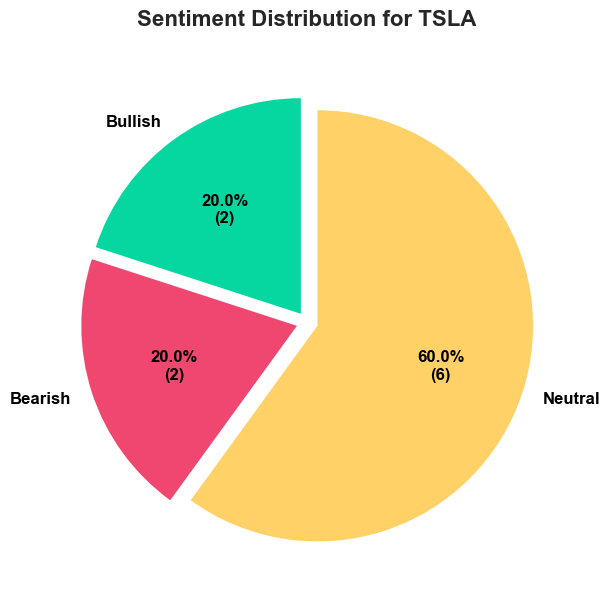

In [72]:
# === VISUALIZATION: Sentiment Pie Chart with Labels on Slices ===
if news:
    # Count sentiments
    sentiments = [get_sentiment_vader(item['title']) for item in news]
    sentiment_counts = {
        'Bullish': sentiments.count('Bullish'),
        'Bearish': sentiments.count('Bearish'),
        'Neutral': sentiments.count('Neutral')
    }

    # Pie chart
    plt.figure(figsize=(10, 7))
    colors = ['#06D6A0', '#EF476F', '#FFD166']  # Bullish, Bearish, Neutral
    explode = (0.05, 0.05, 0.05)
    
    wedges, texts, autotexts = plt.pie(
        sentiment_counts.values(),
        labels=sentiment_counts.keys(),
        autopct=lambda p: f"{p:.1f}%\n({int(p*sum(sentiment_counts.values())/100)})",  # Show % + count
        colors=colors,
        explode=explode,
        startangle=90,
        textprops={'fontsize': 12, 'fontweight': 'bold'}
    )

    # Optional: make labels bolder
    for text in texts + autotexts:
        text.set_color('black')
        text.set_fontsize(12)
        text.set_fontweight('bold')

    plt.title(f'Sentiment Distribution for {ticker}', fontsize=16, fontweight='bold', pad=20)
    
    # Save figure
    filename = f"{ticker}_sentiment_pie.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"📊 Saved: {filename}")
    plt.show()
else:
    print("❌ No data to visualize")

In [73]:


news = fetch_news(ticker, from_date, to_date)

if news:
    # Sentiment counts
    sentiments = [get_sentiment_vader(item['title']) for item in news]
    bullish = sentiments.count('Bullish')
    bearish = sentiments.count('Bearish')
    neutral = sentiments.count('Neutral')
    total = len(news)

    # Overall signal
    if bullish > bearish:
        overall_signal = "Bullish"
    elif bearish > bullish:
        overall_signal = "Bearish"
    else:
        overall_signal = "Neutral"

    # Top keywords
    top_keywords = extract_keywords(news)

    # Final report
    final_report = {
        "ticker": ticker,
        "date_range": f"{from_date} to {to_date}",
        "headlines_analyzed": total,
        "bullish": bullish,
        "bearish": bearish,
        "neutral": neutral,
        "overall_signal": overall_signal,
        "top_keywords": top_keywords
    }

    print(final_report)
else:
    print("❌ No news found for this ticker/date range!")

{'ticker': 'TSLA', 'date_range': '2026-01-01 to 2026-01-25', 'headlines_analyzed': 10, 'bullish': 2, 'bearish': 2, 'neutral': 6, 'overall_signal': 'Neutral', 'top_keywords': [('earnings', 4), ('trump', 3), ('watch', 3), ('week', 3), ('tesla', 2), ('jones', 2), ('futures', 2), ('tariffs', 2), ('government', 2), ('shutdown', 2)]}
